In [2]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

data_dir = '/kaggle/input/flower-classification'
train_dir = data_dir + '/train'

# Define your transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)


In [4]:
# Load a pre-trained network 
model = models.vgg16(pretrained=True)
model.name = "vgg16"
model


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 14, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
# model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [9]:
weights = model.state_dict()['features.0.weight']

In [10]:
bias = model.state_dict()['features.0.bias']

# ==========================================================================

In [11]:
import numpy as np
import skimage.io as io
from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
from time import time

In [12]:
image = io.imread("/kaggle/input/flower-classification/train/astilbe/1052212431_4963309d03_c.jpg")
print(image.shape)

(256, 256, 3)


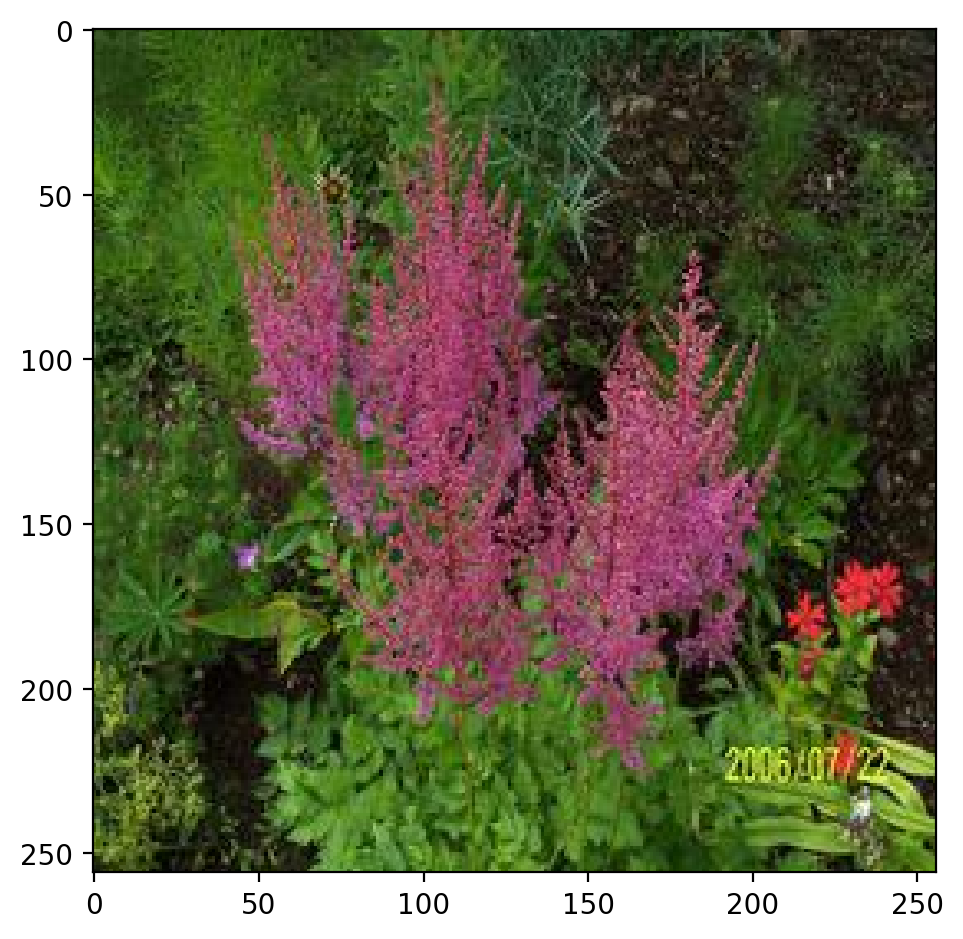

In [13]:
io.imshow(image)
io.show()

In [14]:
def ReLU(z):
    return np.maximum(0, z)

In [15]:
weights = weights.numpy()

In [16]:
def custom_sum(array):
    result = 0
    for element in array:
        result += element
    return result

In [17]:
def conv(image, input_shape, n_filters, filters, kernel_size, stride, activation = 'ReLU'):

    img_h, img_w = input_shape[:2]
    filter_h, filter_w = kernel_size[:]

    #filters = np.random.rand(n_filters, kernel_size[0], kernel_size[1], input_shape[2])

    output_fmaps = []
    fmap_h = (img_h - filter_h)//stride + 1
    fmap_w =  (img_w - filter_w)//stride + 1

    for filter in filters[: , : , :, ]:
        fmap = np.zeros((fmap_h, fmap_w))

        sum = 0
        for i in range(0, stride*fmap_h, stride):
            for j in range(0, stride*fmap_w, stride):
                input_patch = image[i:i+filter_h, j:j+filter_w, :]
                sum = np.sum(input_patch * filter)
                #sum = custom_sum(input_patch * filter)
                fmap[i//stride, j//stride] = ReLU(sum)
        output_fmaps.append(fmap)

    return output_fmaps

In [18]:
layer_1_fmaps = conv(image, image.shape, 64, weights, (3, 3), stride=1)

In [19]:
len(layer_1_fmaps)

64

In [20]:
layer_1_fmaps[0].shape

(254, 254)

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


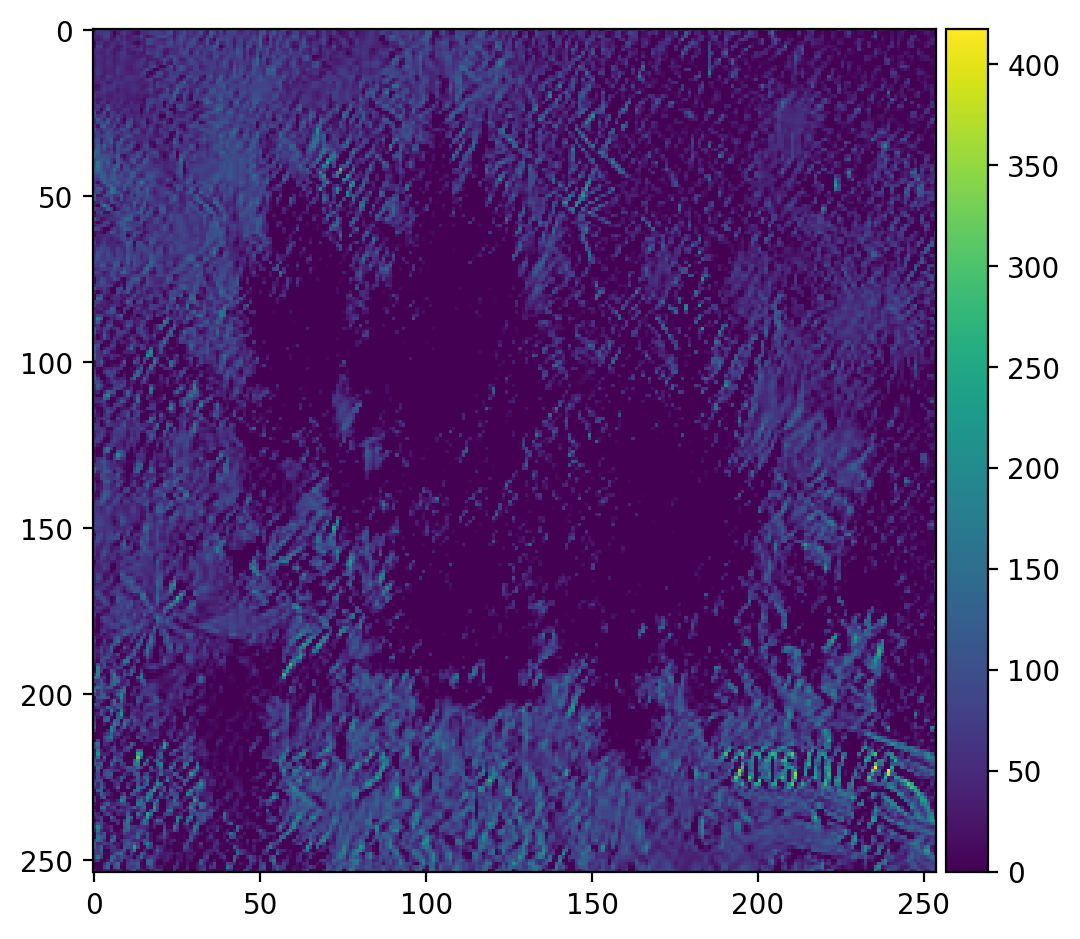

In [21]:
io.imshow(layer_1_fmaps[33])
io.show()

# ==========================================================================

In [22]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define deep learning method
epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [24]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [25]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
print("Training process initializing .....\n")

for e in range(epochs):
    running_loss = 0
    model.train() # Technically not necessary, setting this for good measure
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            model.train()

print("\nTraining process is now complete!!")

Training process initializing .....

Epoch: 1/5 |  Training Loss: 3.8167 |  Validation Loss: 1.0466 |  Validation Accuracy: 0.6769
Epoch: 1/5 |  Training Loss: 0.9888 |  Validation Loss: 0.7984 |  Validation Accuracy: 0.7445
Epoch: 1/5 |  Training Loss: 0.9614 |  Validation Loss: 0.7311 |  Validation Accuracy: 0.7707
Epoch: 1/5 |  Training Loss: 0.8220 |  Validation Loss: 0.6712 |  Validation Accuracy: 0.7883
Epoch: 1/5 |  Training Loss: 0.8575 |  Validation Loss: 0.7155 |  Validation Accuracy: 0.7776
Epoch: 1/5 |  Training Loss: 0.8288 |  Validation Loss: 0.6713 |  Validation Accuracy: 0.7783
Epoch: 2/5 |  Training Loss: 0.4929 |  Validation Loss: 0.6696 |  Validation Accuracy: 0.7726
Epoch: 2/5 |  Training Loss: 0.7878 |  Validation Loss: 0.6424 |  Validation Accuracy: 0.7952
Epoch: 2/5 |  Training Loss: 0.7648 |  Validation Loss: 0.6582 |  Validation Accuracy: 0.7810
Epoch: 2/5 |  Training Loss: 0.7169 |  Validation Loss: 0.6240 |  Validation Accuracy: 0.7788
Epoch: 2/5 |  Training 

In [27]:
all_labels = []
all_predictions = []

In [28]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [29]:
model_children = list(model.children())

In [30]:
model_children[0][0].register_forward_hook(get_activation('cnn_0'))

In [31]:

correct = 0
total = 0
count = 1
with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        all_labels.extend(labels.numpy())
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions.extend(predicted_tensor_cpu.numpy())
        if count == 1:
            break

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))

Accuracy achieved by the network on test images is: 86%


In [32]:
print(activation['cnn_0'].shape)

torch.Size([50, 64, 224, 224])


In [33]:
val = activation['cnn_0'].to('cpu')

In [34]:
print(val[0])

tensor([[[0.0000, 0.2308, 0.2308,  ..., 0.2341, 0.2079, 0.5148],
         [0.0000, 0.2754, 0.2754,  ..., 0.3183, 0.3025, 0.7269],
         [0.0000, 0.2754, 0.2754,  ..., 0.2924, 0.3045, 0.7453],
         ...,
         [6.5131, 0.9040, 0.7342,  ..., 1.7919, 2.3268, 0.0000],
         [6.3895, 1.0383, 0.8608,  ..., 1.7205, 2.2304, 0.0000],
         [5.2936, 2.2894, 2.2307,  ..., 1.7811, 2.2573, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.4912],
         [0.0000, 0.3372, 0.3372,  ..., 0.2124, 0.2583, 4.6671],
         [0.0000, 0.3372, 0.3372,  ..., 0.2654, 0.2711, 4.6695],
         ...,
         [1.0680, 0.3512, 0.7231,  ..., 1.5495, 1.9677, 3.4996],
         [1.0038, 0.6756, 0.8701,  ..., 1.1553, 1.6913, 3.2351],
         [1.7397, 2.1010, 1.9607,  ..., 4.1976, 4.2918, 4.3311]],

        [[3.1963, 4.6997, 4.6997,  ..., 4.2182, 4.3003, 7.1609],
         [0.5309, 0.4600, 0.4600,  ..., 0.4627, 0.4681, 2.7215],
         [0.5309, 0.4600, 0.4600,  ..., 0.4275, 0.4315, 2.

In [35]:
val = val.numpy()

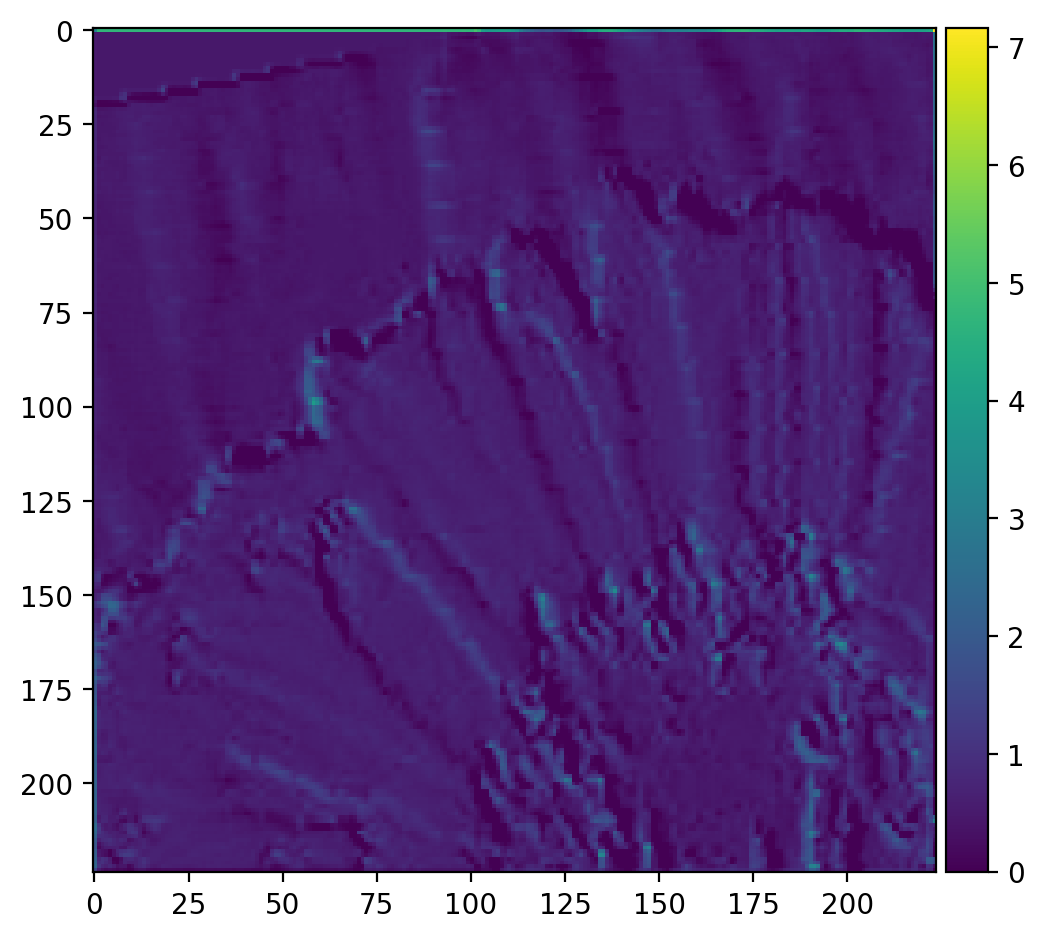

In [36]:
import skimage.io as io
io.imshow(val[0][2])
io.show()

In [37]:
weights = model.state_dict()